In [1]:
import sqlite3 
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd
roots_tfm = '/home/julien/Documents/Etudes/Astrofisica/Master/TFM/Data'

In [2]:
filepath_match = roots_tfm + '/match_uvot_xmm'
dat = Table.read(filepath_match)
df = dat.to_pandas()
df.columns

Index(['SRCNUM_1', 'RA_FLOAT_1', 'DEC_FLOAT_1', 'POSERR_1', 'COUNT_1',
       'SRCNUM_2', 'RA_FLOAT_2', 'DEC_FLOAT_2', 'POSERR_2', 'COUNT_2',
       'Separation'],
      dtype='object')

In [3]:
# Get problematic right ascension edge points
ind = abs(df['RA_FLOAT_1']-df['RA_FLOAT_2'])>10
if len(df[ind].index)>0:
    df_extract = pd.DataFrame(df, columns=['RA_FLOAT_1','RA_FLOAT_2'])
    ind_max = df_extract.loc[ind,:].idxmax(axis=1)
    df.iloc[ind,ind_max]  = df.iloc[ind,ind_max] - 360

# Perform the weighted mean
df['RA'] = (df['RA_FLOAT_1']/df['POSERR_1']+df['RA_FLOAT_2']/df['POSERR_2'])/(1/df['POSERR_1']+1/df['POSERR_2'])
df['DEC'] = (df['DEC_FLOAT_1']/df['POSERR_1']+df['DEC_FLOAT_2']/df['POSERR_2'])/(1/df['POSERR_1']+1/df['POSERR_2'])

# Correct negative point on the edge
df.loc[df.loc[:, 'RA']<0, 'RA'] = df.loc[df.loc[:, 'RA']<0, 'RA'] + 360

# Perform the mean of the position error
df['POSERR'] = (df['POSERR_1']+df['POSERR_2']) / 2

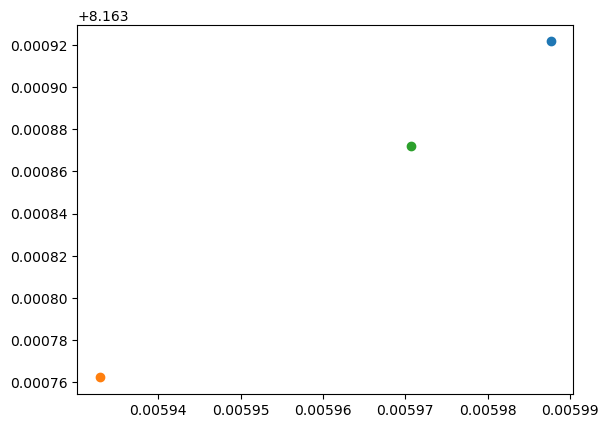

In [4]:
# Print some points to verify it works
plt.scatter(df.loc[1,'RA_FLOAT_1'],df.loc[1,'DEC_FLOAT_1'],color='C0',label='UVOT')
plt.scatter(df.loc[1,'RA_FLOAT_2'],df.loc[1,'DEC_FLOAT_2'],color='C1',label='OM')
plt.scatter(df.loc[1,'RA'],df.loc[1,'DEC'],color='C2',label='Tot')

In [5]:
# Clean unecessary columns
df = df.drop({'RA_FLOAT_1','POSERR_1','RA_FLOAT_2','POSERR_2','DEC_FLOAT_1','DEC_FLOAT_2','Separation'},axis=1)

# Create the total count column and remove the individual one
df['COUNT'] = df['COUNT_1'] + df['COUNT_2']
df = df.drop({'COUNT_1','COUNT_2'},axis=1)
df.head()

,SRCNUM_1,SRCNUM_2,RA,DEC,POSERR,COUNT
0,1,5,0.000164,8.371723,0.427360,2
1,11,102,0.005971,8.163872,0.514480,2
2,20,182,0.010278,8.307732,0.490873,2
3,64,494,0.026404,8.306162,0.514171,2
4,83,599,0.031872,8.295083,0.458900,2


In [6]:
# Load UVOT data per source
filepath_uvot = roots_tfm + '/Swift-UVOT/uvot_ra_dec_per_src.fits'
dat = Table.read(filepath_uvot)
df_uvot = dat.to_pandas()
df_uvot.head()

,SRCNUM,RA,DEC,POSERR,COUNT
0,1,0.000160,8.371681,0.274907,1
1,2,0.000734,8.395096,0.319197,1
2,3,0.000804,81.916291,0.285048,2
3,4,0.001279,-77.007358,0.398002,4
4,5,0.001106,-40.113253,0.535803,1


In [7]:
# Adapt the column format to the match table for the concatenation
df_uvot['SRCNUM_2'] = 0
df_uvot = df_uvot.rename(columns={'SRCNUM':'SRCNUM_1'})
df_uvot=df_uvot[list(df.columns.values)]

In [8]:
# Concatenate the match table with UVOT and remove duplicated raw
df_uvot = pd.concat([df, df_uvot], ignore_index = True).drop_duplicates(subset=['SRCNUM_1'])
df_uvot.shape

(6200016, 6)

In [9]:
df_uvot.dtypes

SRCNUM_1      int32
SRCNUM_2      int64
RA          float64
DEC         float64
POSERR      float64
COUNT         int64
dtype: object

In [10]:
df_uvot = df_uvot.astype({'COUNT': np.uint16, 'SRCNUM_2': np.int32, 'POSERR': np.float32})
df_uvot = df_uvot.sort_values('SRCNUM_1')
#t1 = Table.from_pandas(df_uvot,index=False)
#t1.write(roots_tfm + '/Swift-UVOT/SOURCE_UVOT.fits',overwrite='True')

In [11]:
# Load OM data per source and prepare the column format to the concatenation
filepath_om = roots_tfm + '/XMM-Newton/SUSS6_ra_dec_per_src.fits'
dat = Table.read(filepath_om)
df_om = dat.to_pandas()
df_om['SRCNUM_1'] = 0
df_om = df_om.rename(columns={'SRCNUM':'SRCNUM_2'})
df_om=df_om[list(df.columns.values)]

In [12]:
# Concatenate OM data with match table and remove the duplicated raw
#df_om = pd.concat([df, df_om], ignore_index = True).drop_duplicates(subset=['SRCNUM_2'])
#df_om.shape

In [13]:
df_om.dtypes

SRCNUM_1      int64
SRCNUM_2      int64
RA          float64
DEC         float64
POSERR      float32
COUNT         int64
dtype: object

In [14]:
df_om = df_om.astype({'SRCNUM_1': np.int32, 'COUNT': np.uint16, 'SRCNUM_2': np.int32, 'POSERR': np.float32})
df_om = df_om.sort_values('SRCNUM_2')
#t1 = Table.from_pandas(df_om,index=False)
#t1.write(roots_tfm + '/XMM-Newton/SOURCE_OM.fits',overwrite='True')

In [15]:
# Concatenate the tables of both catalogue droping match duplicated
#df_tot = dd.concat([dd.from_pandas(df_uvot,npartitions=2), dd.from_pandas(df_om,npartitions=2)]).drop_duplicates()
df_tot = pd.concat([df_uvot, df_om], ignore_index = True).drop_duplicates()
#df_tot.shape

In [16]:
#df_tot.to_csv(roots_tfm + '/SOURCE_complete.csv',index=True)

In [17]:
#df_tot.loc[df_tot.loc[:,'COUNT']>2,'COUNT'].shape

In [18]:
#df_tot.head()

In [19]:
#df_tot.dtypes

In [20]:
#t1 = Table.from_pandas(df_tot,index=True)
#t1.write(roots_tfm + '/SOURCE_complete.fits',overwrite='True')

In [21]:
#t1 = Table.from_pandas(df_tot.loc[df_tot.loc[:,'COUNT']>2,:],index=True)
#t1.write(roots_tfm + '/SOURCE_selection_count_sup_2.fits',overwrite='True')

In [23]:
db_path ='sqlite:///'+ roots_tfm + '/UVCatalogue.db'
df_tot.to_sql("SOURCES", db_path, if_exists='replace', index=True, chunksize=1000, method="multi")

12859570